<a href="https://colab.research.google.com/github/Cod-lang/Face_similarity_with-siamese_in_Pytorch/blob/main/Find_Label_of_unknown_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import PIL.ImageOps  
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random 
import os
import sys

In [3]:
def imshow(img, text=None, should_save=False):
    npimg = img.numpy() # channel, hight, width = (0, 1, 2)
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (1, 2, 0) = channel last notation
    plt.show()   

def show_plot(iteration,loss):
    plt.plot(iteration, loss)
    plt.show()

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),  #padding
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),                                   
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),                                       


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),  

            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),          
                                                     
        )

        self.fc1 = nn.Sequential(
            nn.Linear(16*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 256) 
            ) 

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)                                      # flattening
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    def imgfeature(self,inp):
        # to get the representations of train and test
        fet = self.forward_once(inp)
        return fet

In [6]:
net = SiameseNetwork().cuda()                           #input_size, hidden1_size, hidden2_size, num_classes         #model = TheModelClass(*args, **kwargs)

#net = torch.load('get_name.h5')               # torch.save(net,'model.h5')

net.load_state_dict(torch.load('get_class.pth'))


<All keys matched successfully>

In [7]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    unknown_dir = "./data/faces/unknown/"


Reading the images-features csv file and preparing the feature-set and target set 

In [8]:
##  Reading the image_feature csv file
feature_df= pd.read_csv('Features_with_class.csv')
#Preparing feature and target for training classification model
X = feature_df.iloc[:, 0:256].values
y = feature_df.iloc[:,256].values

### Applying a classification algorithm on the Image-Feature dataset 

Applying Multi-layer Perceptron classifier 

In [11]:
 from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

 X = feature_df.iloc[:, 0:256].values
y = feature_df.iloc[:,256].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 50)
scaler.fit_transform(x_train)
scaler.fit(x_test)
skn= MLPClassifier(alpha=1e-07, random_state=30, max_iter=500, activation='relu', solver='adam', learning_rate='invscaling').fit(x_train, y_train)
y_prob = skn.predict_proba(x_test)

pred = skn.predict(x_test)

mas = skn.score(x_test, y_test)                # Return the mean accuracy on the given test data and labels.
 print('mean accuracy ', mas )

skn_df = pd.DataFrame(pred, columns=['predictions'])
skn_df[' true']=y_test
#skn_df.head(20)

mean accuracy  0.815068493150685


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


###Taking one by one each image from the unkown folder , passing it through trained neural-network model, and extracting its features.

In [12]:
unknown_folder_set = dset.ImageFolder(root=Config.unknown_dir)
img_file_list=[]                                           # creating an empty list to contain all  image's files from all the unknown folder.

img_file_list = [x for x in unknown_folder_set.imgs]

transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])

feat = []
img_cls = []
path_img =[]
for y in img_file_list:                                                                                        #  img_file_list ----->>    compare
    check_img  =  Image.open(y[0])           # y[0] contains the file-path of image-file
    ch_img = check_img.convert("L")  
    ch_img = transform(ch_img)      
    ch_img_us =torch.unsqueeze(ch_img,0)
    output = net.imgfeature(Variable(ch_img_us).cuda())  # applying the nn model to get the features of images

    ch_img_features = output.cpu().detach().numpy()
    feat.append(ch_img_features)
    img_cls.append(y[0].split('/')[-2] )       # list containig the class of image
    path_img.append(y[0])                                 # list containing image file path


Preparing a reference Dataframe containing the unknown folder's images' (256)features-values, their true class(to cross check) and their file-path.

In [13]:
feat = np.reshape(feat,(-1,256))
ref_df = pd.DataFrame(feat)
ref_df['class'] = img_cls
ref_df['path'] = path_img

### **Predict the unknown-folder images using the classifier**

Predict the images' class from hteir features, and save the result in a new column of the above reference-dataframe .

In [14]:
# predict from MLP classifier
ref_df['Prediction'] = skn.predict(feat)
ref_df.iloc[:,256:]

,class,path,Prediction
0,AnushkaShetty,./data/faces/unknown/AnushkaShetty/Copy of a10...,AnushkaShetty
1,DavidBeckham,./data/faces/unknown/DavidBeckham/Copy of d8.jpg,DavidBeckham
2,KanganaRanaut,./data/faces/unknown/KanganaRanaut/Copy of k7.jpg,KanganaRanaut
3,MadhuriDixit,./data/faces/unknown/MadhuriDixit/Copy of m5.jpg,MadhuriDixit
4,MaheshBabu,./data/faces/unknown/MaheshBabu/M9.jpg,MaheshBabu
5,Prabhas,./data/faces/unknown/Prabhas/Copy of p5.jpeg,Prabhas
6,RobertDrowneyJr,./data/faces/unknown/RobertDrowneyJr/Copy of r...,RobertDrowneyJr
7,TomCruise,./data/faces/unknown/TomCruise/Copy of t1.jpg,TomCruise
8,YamiGautam,./data/faces/unknown/YamiGautam/Copy of y1.jpg,YamiGautam


See the extracted features for each picture from the unknown folder and their True and Predicted labels (path of the image files is included to visualise the images)

In [15]:
ref_df  # see the extracted features for each picture from the unknown folder and their True and Predicted labels

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,class,path,Prediction
0,0.055156,0.012334,0.002400,0.040621,0.046463,-0.071946,-0.013262,0.006984,0.000375,-0.015652,0.014719,-0.024023,-0.001657,0.018294,-0.041782,-0.005995,0.044307,1.360428,-0.082102,-0.119513,-0.027669,0.026800,0.118468,-0.314779,0.126479,-0.022765,-0.028371,0.018218,-0.035363,-0.190872,0.024636,0.025530,0.037987,0.043506,0.010659,0.008417,-0.035856,-0.022782,-0.034719,-0.015858,...,0.021032,0.009612,-0.044143,0.041590,-0.022602,-0.133170,0.002622,0.046481,0.025463,0.003832,-0.039780,0.001141,0.026124,0.325744,0.027935,0.020231,-0.045648,0.009009,-0.120425,-0.034506,-0.022033,-0.044106,0.026872,-0.059905,-0.124105,0.009479,-0.281653,0.010032,-0.003106,-0.007460,0.052225,0.028894,-0.032880,-0.025628,0.019204,-0.038055,0.004424,AnushkaShetty,./data/faces/unknown/AnushkaShetty/Copy of a10...,AnushkaShetty
1,0.007914,0.011363,-0.006372,0.017854,0.044304,0.019050,-0.012261,0.012949,0.001790,-0.015683,0.013894,0.002988,0.000148,0.020248,-0.012453,-0.008805,0.038185,0.301110,-0.046015,-0.057095,-0.026488,0.027779,0.032624,-0.051068,0.020286,-0.013485,-0.027579,0.018721,-0.036181,-0.067175,0.022355,0.025331,0.038165,0.039964,0.006322,-0.004681,-0.041459,-0.012867,-0.039400,0.002994,...,0.020528,0.008698,-0.044175,0.033853,-0.003873,0.001043,0.006272,0.043853,0.030751,0.010390,-0.036417,0.000954,0.029590,0.101655,0.027221,0.013537,-0.041930,0.016285,-0.025156,-0.034461,-0.015848,-0.042609,0.022833,-0.016687,-0.007977,0.002340,-0.038029,0.008922,0.016990,-0.001809,0.040710,0.033209,-0.033462,-0.028777,0.023865,0.005175,-0.009164,DavidBeckham,./data/faces/unknown/DavidBeckham/Copy of d8.jpg,DavidBeckham
2,0.048110,0.012073,-0.000789,0.036601,0.046016,-0.077256,-0.011901,0.007765,0.003954,-0.015904,0.014807,-0.033654,-0.001742,0.018530,-0.015307,-0.007044,0.043475,0.991291,-0.076121,-0.117538,-0.025752,0.033683,0.086116,-0.218643,0.085081,-0.021349,-0.028936,0.018321,-0.036296,-0.246699,0.023990,0.029859,0.038081,0.042592,0.010043,0.003603,-0.037066,0.020137,-0.035045,-0.013119,...,0.020835,0.009279,-0.044153,0.039304,-0.019759,-0.135888,0.004343,0.046083,0.026629,0.004970,-0.039190,0.001072,0.027630,0.254932,0.031299,0.019133,-0.044407,0.011646,-0.085413,-0.034483,-0.019784,-0.043809,0.025576,-0.054091,0.081159,0.009367,-0.342922,0.009819,0.003754,-0.005530,0.050208,0.030739,-0.032997,-0.025941,0.020875,-0.011604,0.010549,KanganaRanaut,./data/faces/unknown/KanganaRanaut/Copy of k7.jpg,KanganaRanaut
3,0.015454,0.011431,-0.003659,0.017562,0.042516,-0.031166,-0.017844,0.010095,0.044570,-0.016969,0.015029,0.000696,-0.000105,0.020649,-0.019595,-0.008384,0.041510,1.069969,-0.055878,-0.089413,-0.024726,0.036087,0.075790,-0.177037,0.072029,-0.017206,-0.028156,0.019544,-0.036283,-0.345515,0.026346,0.047243,0.038192,0.040978,0.008703,0.001003,-0.038935,0.011043,-0.037594,-0.001016,...,0.020655,0.008938,-0.044092,0.039647,-0.008473,-0.106858,0.008218,0.045364,0.027110,0.007522,-0.035862,0.000988,0.029519,0.329642,0.056502,0.016148,-0.041831,0.014229,-0.099094,-0.034463,-0.018828,-0.043306,0.023462,-0.041339,0.152034,0.010437,-0.422816,0.009177,0.017772,-0.003360,0.046182,0.033500,-0.033212,-0.027418,0.023467,-0.014562,0.052047,MadhuriDixit,./data/faces/unknown/MadhuriDixit/Copy of m5.jpg,MadhuriDixit
4,0.001564,0.011228,-0.007625,0.014769,0.044009,0.030536,-0.012079,0.013746,0.002117,-0.015697,0.013792,0.006083,0.000377,0.020509,-0.007643,-0.009207,0.037366,0.150498,-0.041142,-0.048995,-0.026260,0.028176,0.020321,-0.013399,0.005012,-0.012237,-0.027500,0.018789,-0.036323,-0.053497,0.022037,0.025478,0.038192,0.039472,0.005740,-0.006554,-0.042226,-0.009904,-0.040014,0.005525,...,0.020455,0.008567,-0.044180,0.032769,-0.001354,0.018181,0.006809,0.043499,0.031476,0.011278,-0.

### **Displaying the images along with their predicted class**

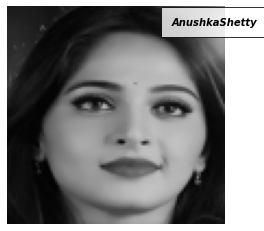

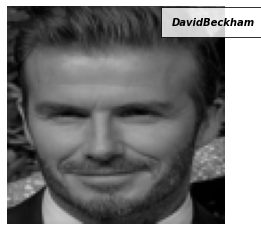

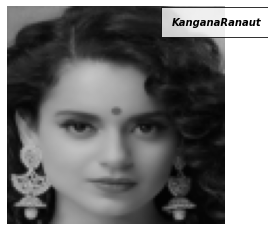

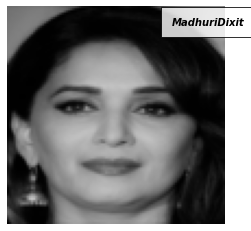

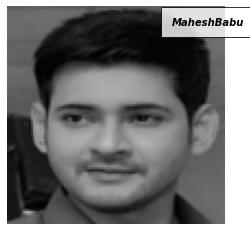

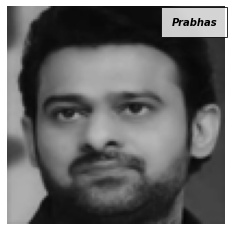

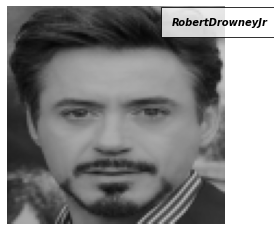

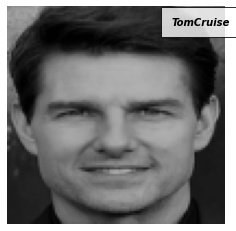

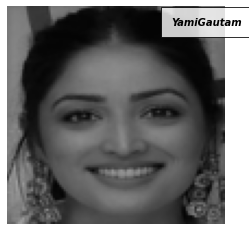

In [16]:
for i in range(len(ref_df)):

  path = ref_df['path'].values[i]
  display = transform(Image.open(path).convert('L'))
  imshow(torchvision.utils.make_grid(display),  ref_df['Prediction'].values[i])

**So the classifier is able to correctly identify all of the 9 images from the unknown folder.**